In [1]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import numpy as np
import geopandas as gpd 
from scipy.cluster import hierarchy
import sklearn.metrics as skm

%matplotlib inline

In [2]:
dict_ine_name= {'02': 'Albacete',
 '03': 'Alicante/Alacant',
 '04': 'Almería',
 '01': 'Araba/Álava',
 '33': 'Asturias',
 '05': 'Ávila',
 '06': 'Badajoz',
 '07': 'Balears Illes',
 '08': 'Barcelona',
 '48': 'Bizkaia',
 '09': 'Burgos',
 '10': 'Cáceres',
 '11': 'Cádiz',
 '39': 'Cantabria',
 '12': 'Castellón/Castelló',
 '13': 'Ciudad Real',
 '14': 'Córdoba',
 '15': 'Coruña A',
 '16': 'Cuenca',
 '20': 'Gipuzkoa',
 '17': 'Girona',
 '18': 'Granada',
 '19': 'Guadalajara',
 '21': 'Huelva',
 '22': 'Huesca',
 '23': 'Jaén',
 '24': 'León',
 '25': 'Lleida',
 '27': 'Lugo',
 '28': 'Madrid',
 '29': 'Málaga',
 '30': 'Murcia',
 '31': 'Navarra',
 '32': 'Ourense',
 '34': 'Palencia',
 '35': 'Palmas Las',
 '36': 'Pontevedra',
 '26': 'Rioja La',
 '37': 'Salamanca',
 '38': 'Santa Cruz de Tenerife',
 '40': 'Segovia',
 '41': 'Sevilla',
 '42': 'Soria',
 '43': 'Tarragona',
 '44': 'Teruel',
 '45': 'Toledo',
 '46': 'Valencia/València',
 '47': 'Valladolid',
 '49': 'Zamora',
 '50': 'Zaragoza',
 '51': 'Ceuta',
 '52': 'Melilla'}

In [3]:
dict_name_ine = {}
for k, v in dict_ine_name.items():
    dict_name_ine[v] = k

In [4]:
gdf = gpd.read_file('Map/Provinces.shp', encoding='utf-8') 
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].centroid
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')

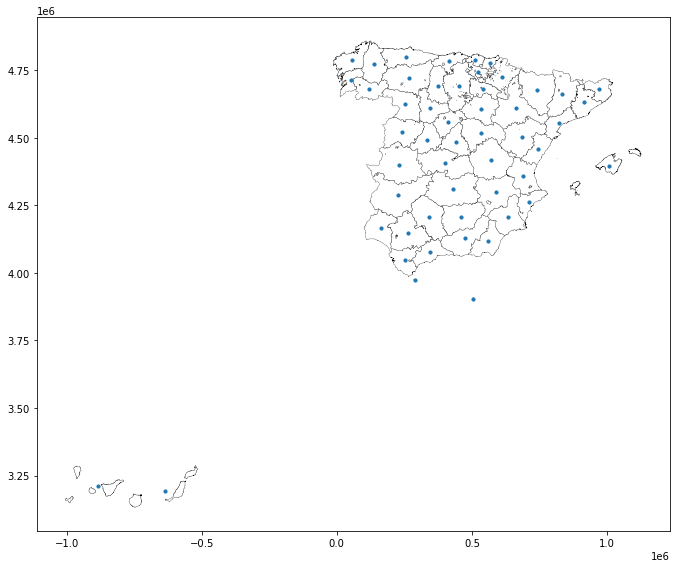

In [5]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(10, 8), linewidth=0.25)
gdf_points.plot(ax=ax, markersize=10)
plt.tight_layout()

In [6]:
def preprocess(path):
    dtypes = {"Origen":str,
              "Destino":str,
              "Año":str,
              "Mes":str,
              "Día":str,
              "Periodo":str,
              "Modo":str,
              "Distancia":str,
              "Residencia":str,
              "Actividad_Origen":str,
              "Actividad_Destino":str,
              "Viajeros":str,
              "Viajeros-km":str}
    df = pd.read_csv(path, encoding="utf-8", dtype=dtypes)
    df['Viajeros'] = df['Viajeros'].str.replace(r'\,','').astype(float)
    df['Viajeros-km'] = df['Viajeros-km'].str.replace(r'\,','').astype(float)
    df['Origen2'] = df['Origen'].apply(lambda z: z[:2])
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df

In [7]:
def get_destino_distribution(df,Origen):
    destino_distribution = df[df.Origen2 == Origen].groupby('Destino2').Viajeros.sum().to_frame('weight')
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame([str(z).zfill(2) for z in range(1, 53)], columns=['Destino2'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='Destino2', how='outer')
    destino_distribution.weight.fillna(0, inplace=True)
    destino_distribution['norm_weight'] = destino_distribution['weight'] / destino_distribution['weight'].sum()
    destino_distribution.sort_values('norm_weight', ascending=False, inplace=True)
    return destino_distribution

In [8]:
def plot_signiture(df,title,scale = None):
    plt.figure()
    rank = list(range(1, 53))
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df,Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

    plt.subplot(1, 1, 1)
    for i in range(1, 53):
        destino_distribution = destino_distributions[str(i).zfill(2)]
        plt.plot(rank, destino_distribution.norm_weight, color='blue', alpha=0.5)
    plt.xlabel('Rank')
    plt.ylabel('Fraction')
    if scale == 'log':
            plt.yscale('log')
            #plt.ylim([-0.1, 1.1])
    plt.title(f'Mobility signiture for {title}')
    plt.tight_layout()

In [9]:
def get_distance_matrix(df):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df, Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

    
    dist_mat = []
    destino_dist_avg = {}
    for i in range(1, 53):
        origen_i = str(i).zfill(2)
        array_i = []
        for j in range(1, 53):
            origen_j = str(j).zfill(2)
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    return dist_mat

In [10]:
def plot_distance_matrix(dist_mat):
    plt.figure(figsize=(14, 14))
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], rotation=90)
    plt.yticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)])
    plt.title('distance matrix')

In [11]:
def num_clusters(Linkage_matrix, thr):
    
    return len(np.unique(fcluster(Linkage_matrix, thr, criterion='distance')))


In [12]:
def plot_dendrogram(dist_mat, thr,linkage_method):
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    hierarchy.set_link_color_palette(colors)
    plt.figure(figsize=(12, 6))
    x = linkage(dist_mat,linkage_method)
    g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
    plt.axhline(y=thr, ls=':', color='k')
    plt.ylabel("Distance")
    plt.title(f'Linkage method:{linkage_method}')
    plt.tight_layout()

    plt.savefig(f"{linkage_method}.pdf")
    return g

In [13]:
def plot_clustered_cities(group, title_name):
    #colors = np.unique(group['leaves_color_list']).tolist()
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    group_coord = {}
    for color in color_city_group_dict.keys():
        cities = color_city_group_dict[color]
        group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   


    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(10,8))
    ax.set_title(title_name)
    for color,coord in group_coord.items() :
        gdf_points[gdf_points.CPRO.isin(coord)].plot(ax=ax, color=color, legend=True)
        gdf[gdf.CPRO.isin(coord)].plot(ax=ax, color=color, alpha=0.2)


In [14]:
def plot_groups(group,df,scale = None):
    group_avg = []
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]
    unique_colors = np.unique(group['leaves_color_list']).tolist()
    num_cluster = len(unique_colors)
    plt.figure(figsize=(5 * num_cluster, 5))  
    for i ,select_group in enumerate(color_city_group_dict.values()):
        plt.subplot(1, num_cluster, i+1)
        arr_avg = np.array([0.0] * 52)
        for name in select_group:
            ine = dict_name_ine[name]
            distribution = get_destino_distribution(df, ine)
            rank = list(range(1, 53))
            plt.bar(rank,distribution.norm_weight.tolist(), color=unique_colors[i], alpha=1/len(select_group))
            arr_avg += distribution.norm_weight.tolist()
        arr_avg /= len(select_group)

        group_avg.append(arr_avg)
        plt.plot(rank,arr_avg, color='black', ls='--',linewidth=6)
        if scale == 'log':
            plt.yscale('log')
            plt.ylim([0.00001, 1.1])

        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.xlim([-1, 53])
        plt.title('group %d' % (i+1))
        plt.tight_layout()
    return group_avg

In [15]:
def plot_average_clusters(group,group_avg, scale = None):    
    plt.figure(figsize=(5, 5))
    rank = list(range(1, 53))
    unique_colors = np.unique(group['leaves_color_list']).tolist()

    for i in range(len(group_avg)):
        plt.plot(rank, group_avg[i], color=unique_colors[i], ls='-', label='group %d' % (i+1))
        plt.legend()
        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.title('Average of groups')
        plt.xlim([-1, 53])
        if scale == 'log':
            plt.yscale('log')
            plt.ylim([0.00001, 1.1])
        plt.tight_layout()


<ipython-input-12-5a2bf0b01af2>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,linkage_method)


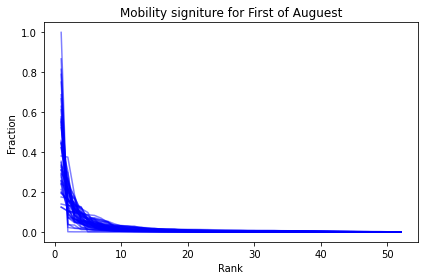

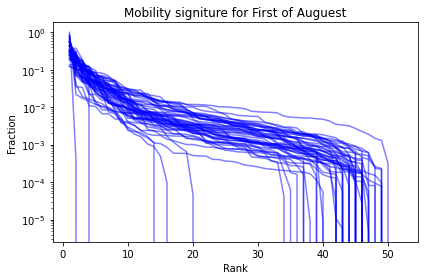

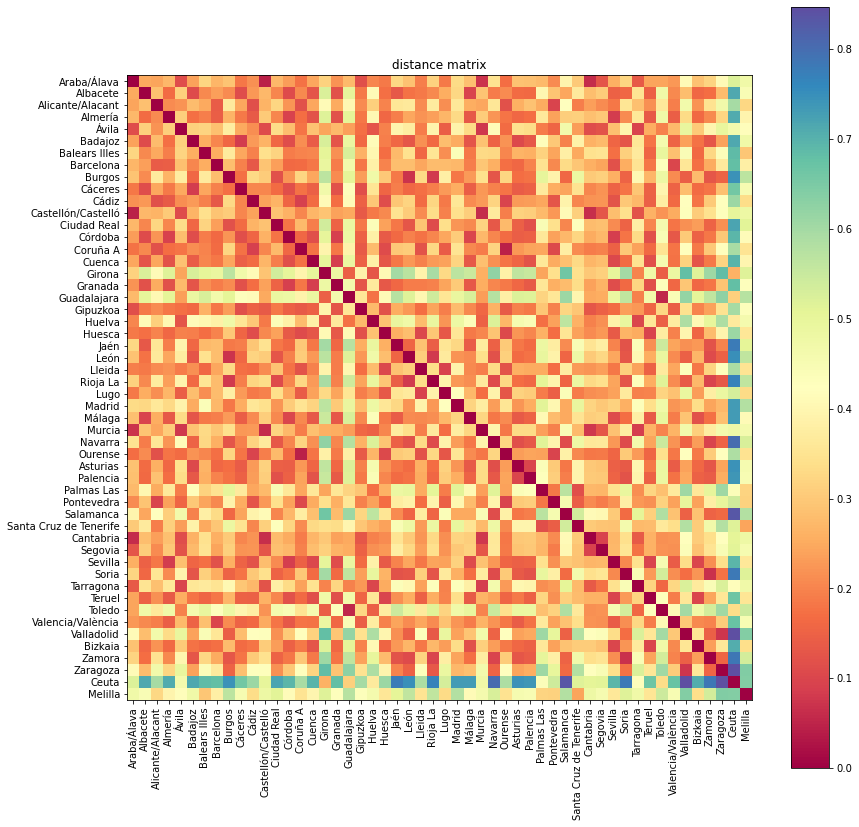

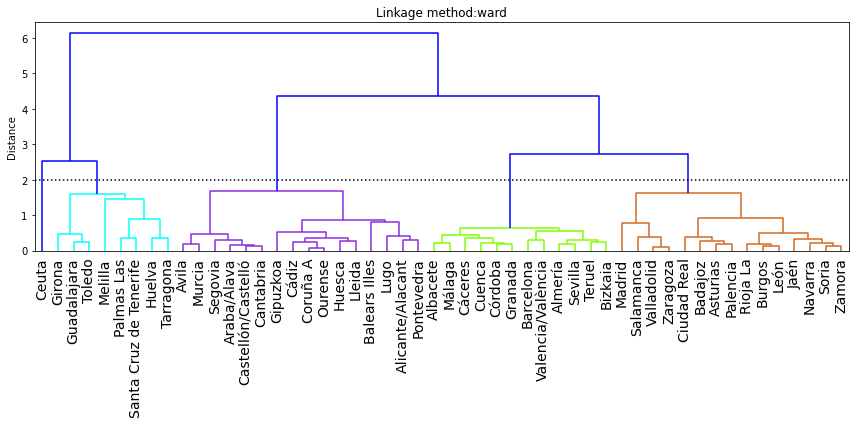

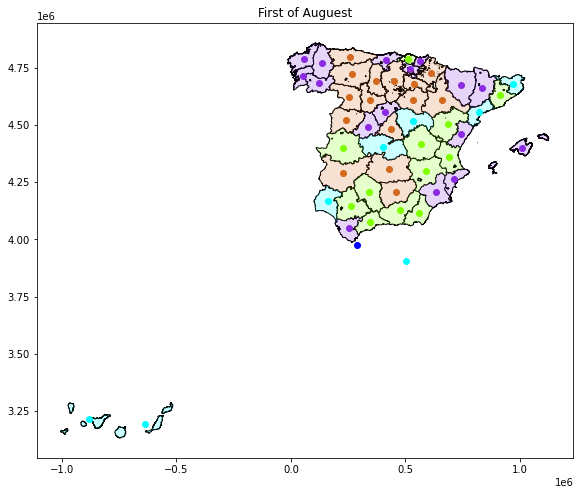

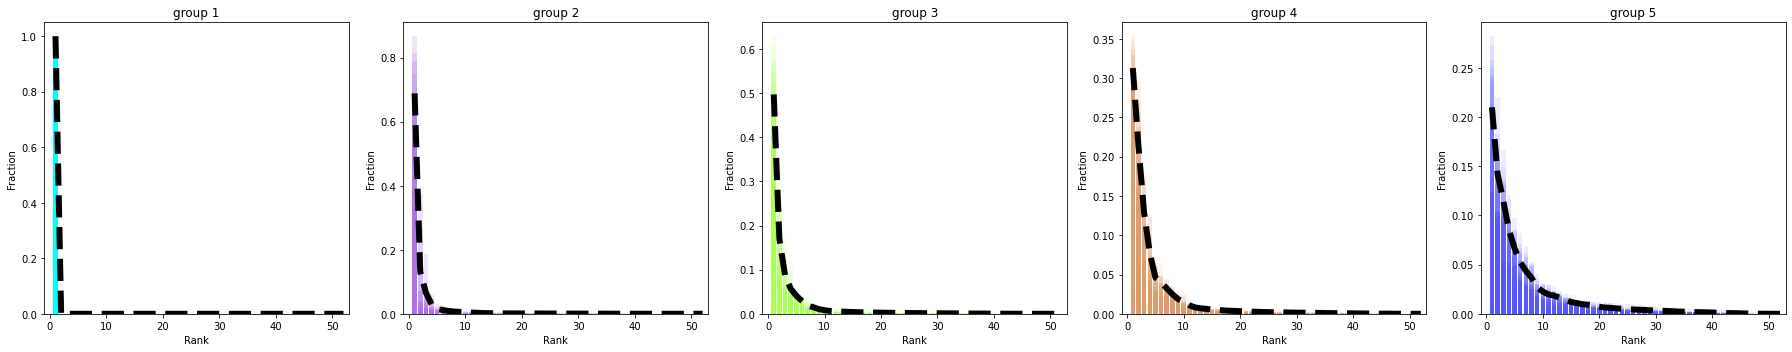

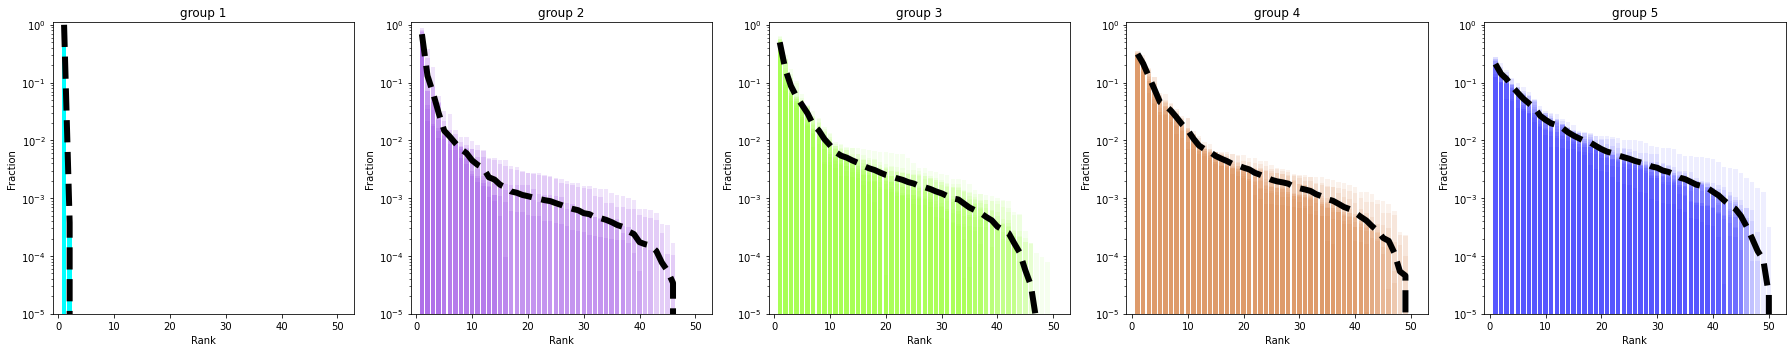

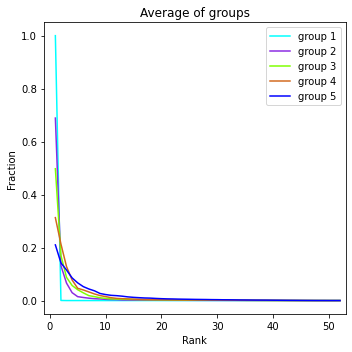

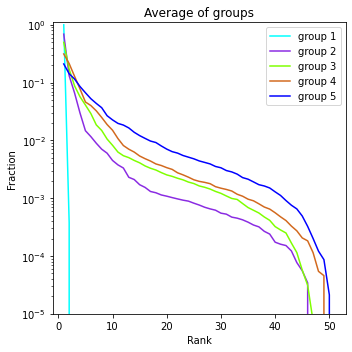

In [16]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'First of Auguest'
thr = 2
linkage_method = 'ward'
df = preprocess(path)
plot_signiture(df,title_name)
plot_signiture(df,title_name, scale = 'log')
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
group = plot_dendrogram(dist_mat,thr, linkage_method)
plot_clustered_cities(group, title_name)
group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = None)
plot_average_clusters(group,group_avg, scale = 'log')

In [20]:
#skm.calinski_harabasz_score(x)#, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)])


array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.        , 0.51782531, 1.        ],
       [0.        , 0.        , 0.53565062, 1.        ],
       ...,
       [0.53565062, 0.        , 0.        , 1.        ],
       [0.51782531, 0.        , 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

<ipython-input-12-5a2bf0b01af2>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,linkage_method)


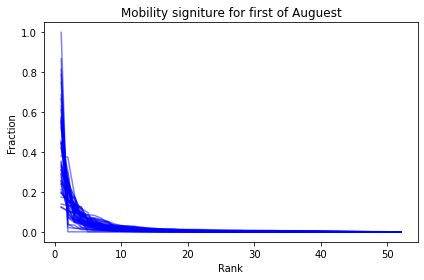

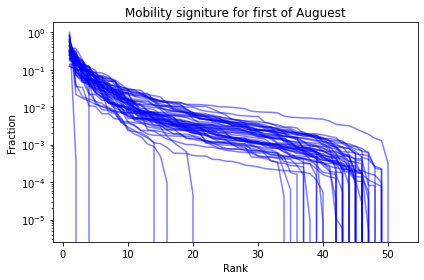

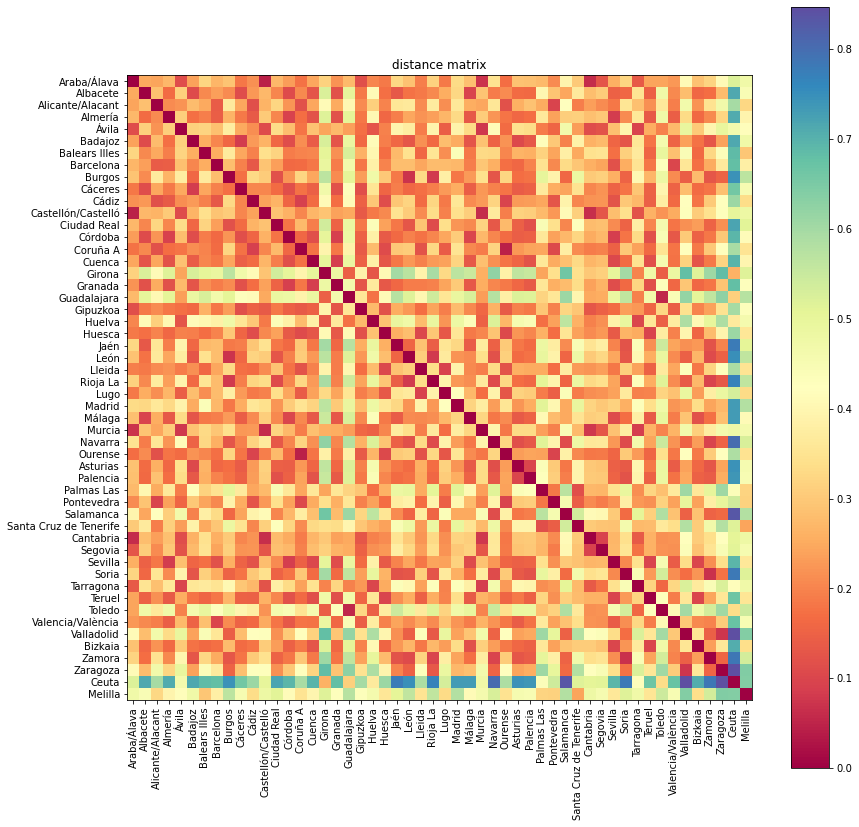

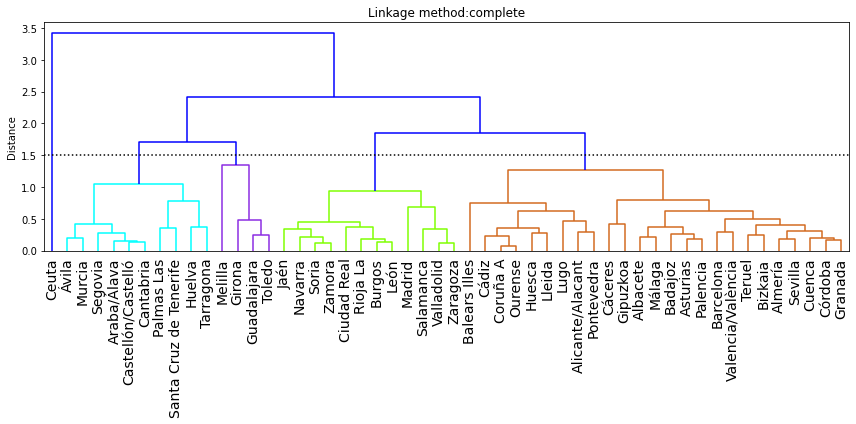

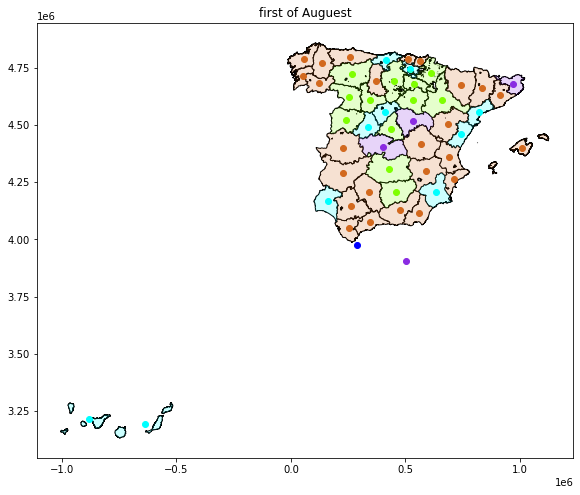

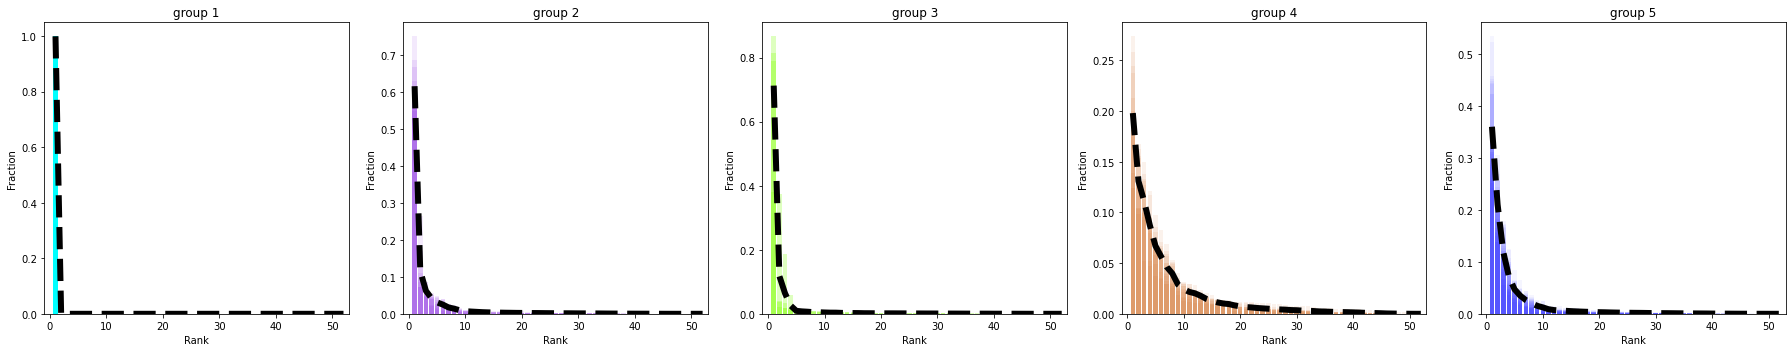

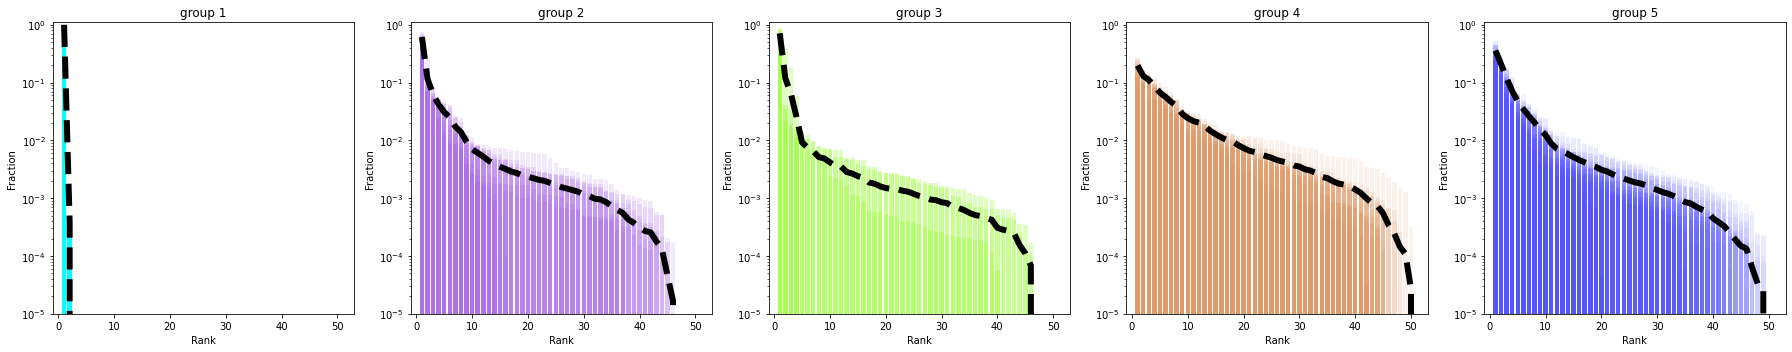

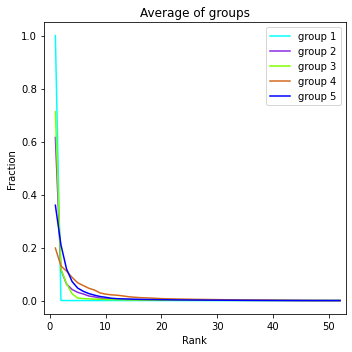

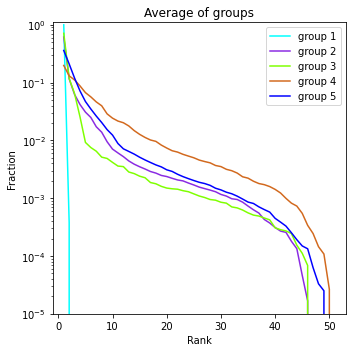

In [21]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'first of Auguest'
thr = 1.5
linkage_method = 'complete'
df = preprocess(path)
plot_signiture(df,title_name)
plot_signiture(df,title_name, scale = 'log')
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
group = plot_dendrogram(dist_mat,thr, linkage_method)
plot_clustered_cities(group, title_name)
group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = None)
plot_average_clusters(group,group_avg, scale = 'log')

<ipython-input-12-5a2bf0b01af2>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,linkage_method)


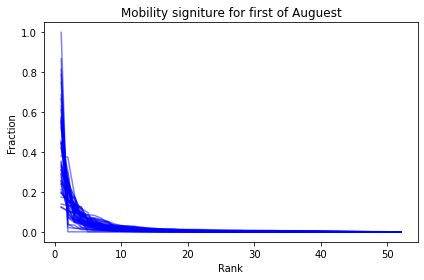

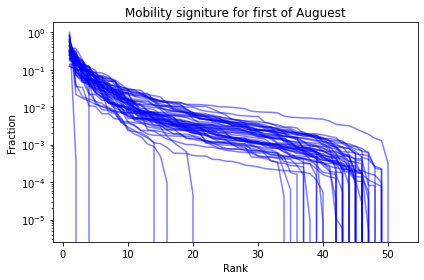

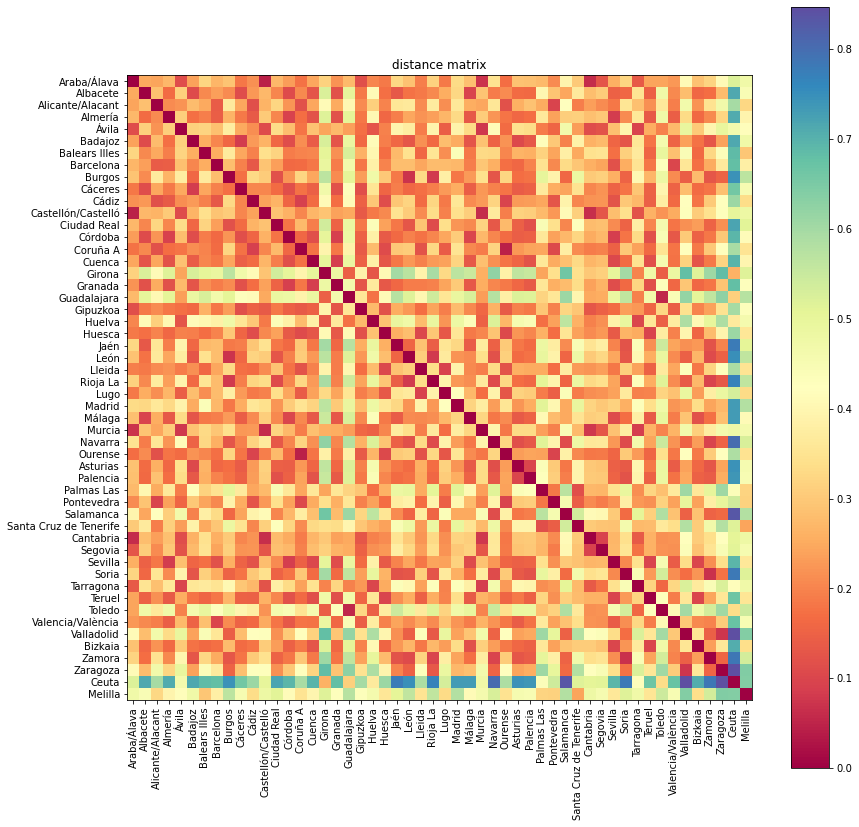

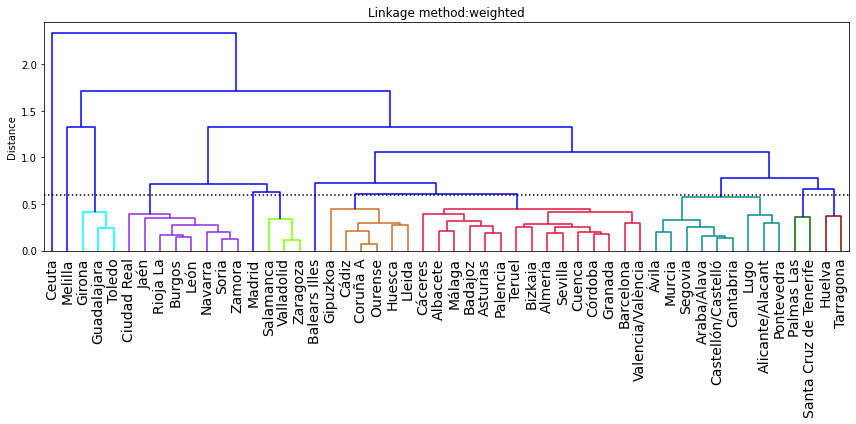

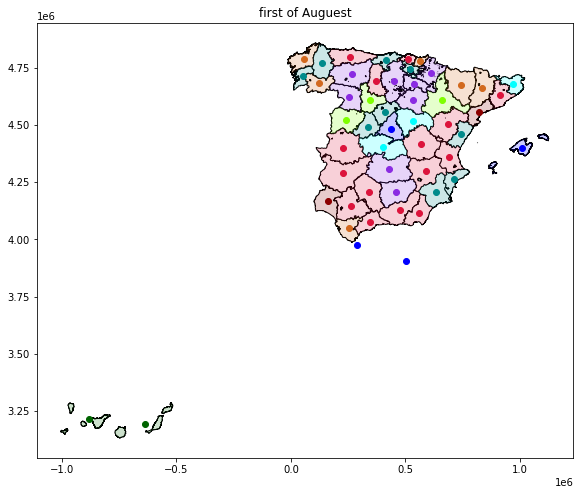

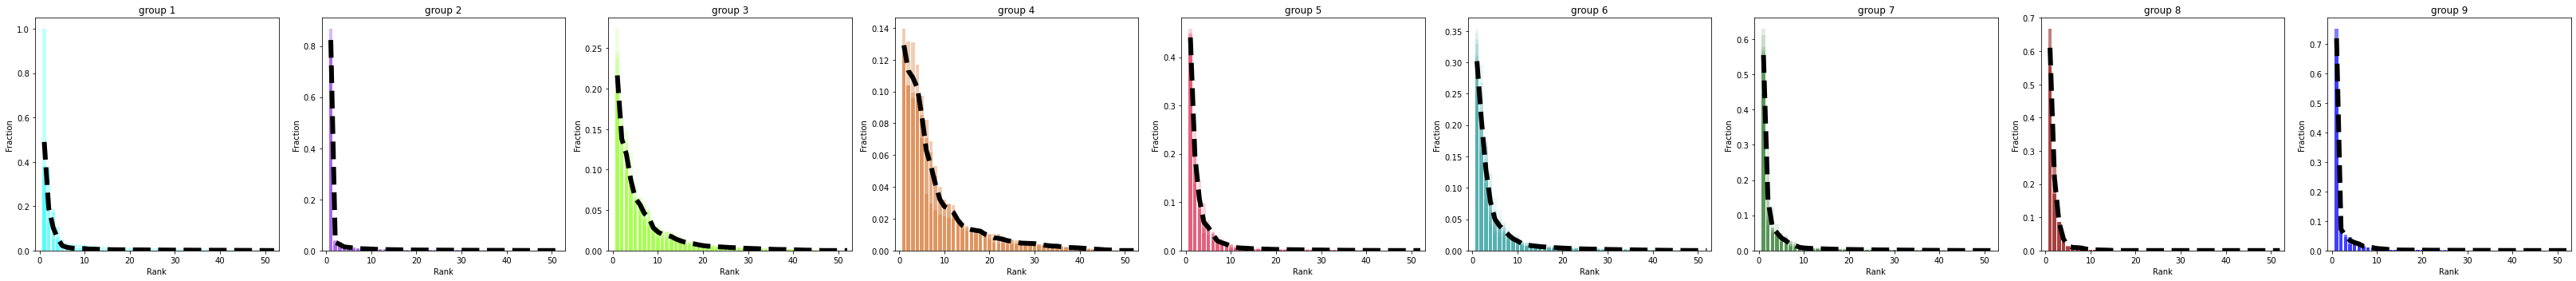

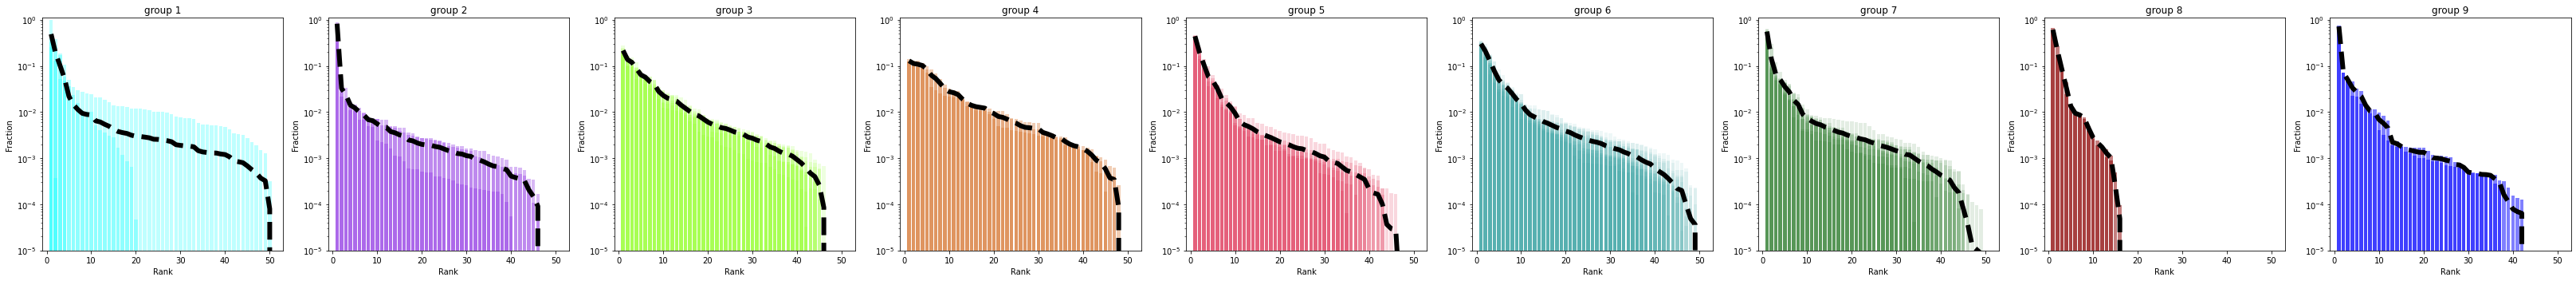

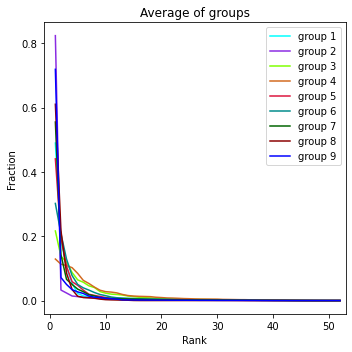

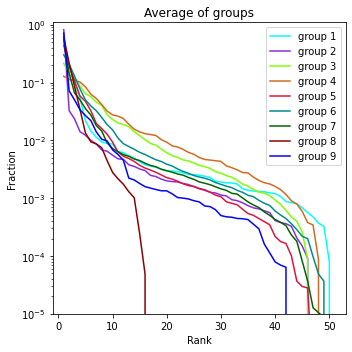

In [22]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'first of Auguest'
thr = 0.6
linkage_method = 'weighted'
df = preprocess(path)
plot_signiture(df,title_name)
plot_signiture(df,title_name, scale = 'log')
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
group = plot_dendrogram(dist_mat,thr, linkage_method)
plot_clustered_cities(group, title_name)
group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = None)
plot_average_clusters(group,group_avg, scale = 'log')

<ipython-input-12-5a2bf0b01af2>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,linkage_method)


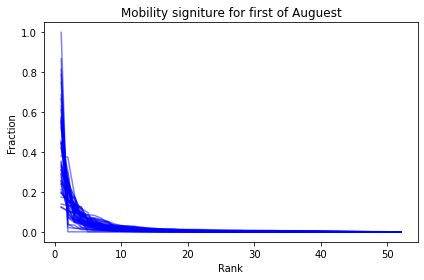

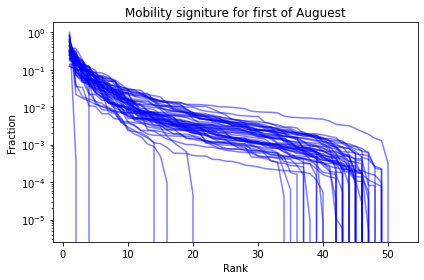

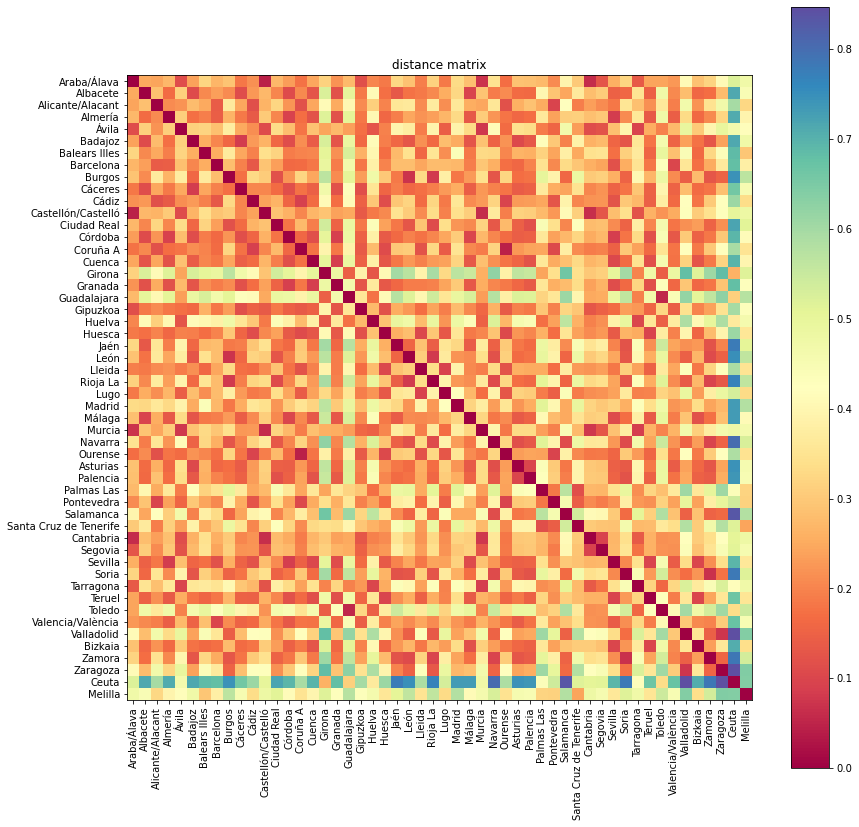

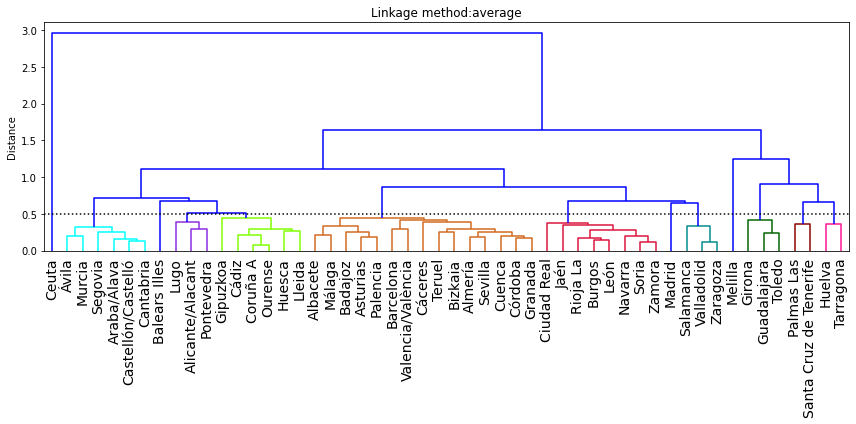

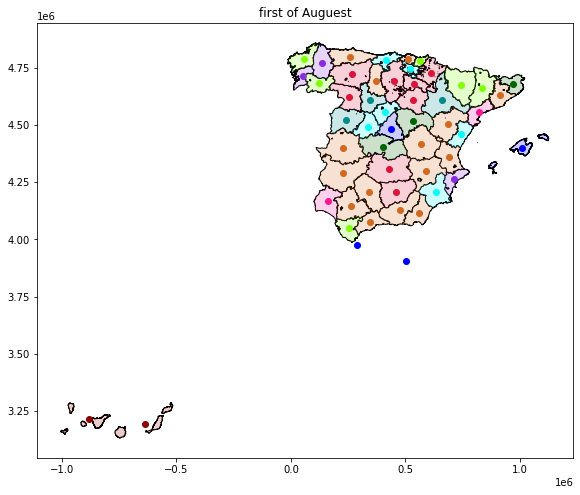

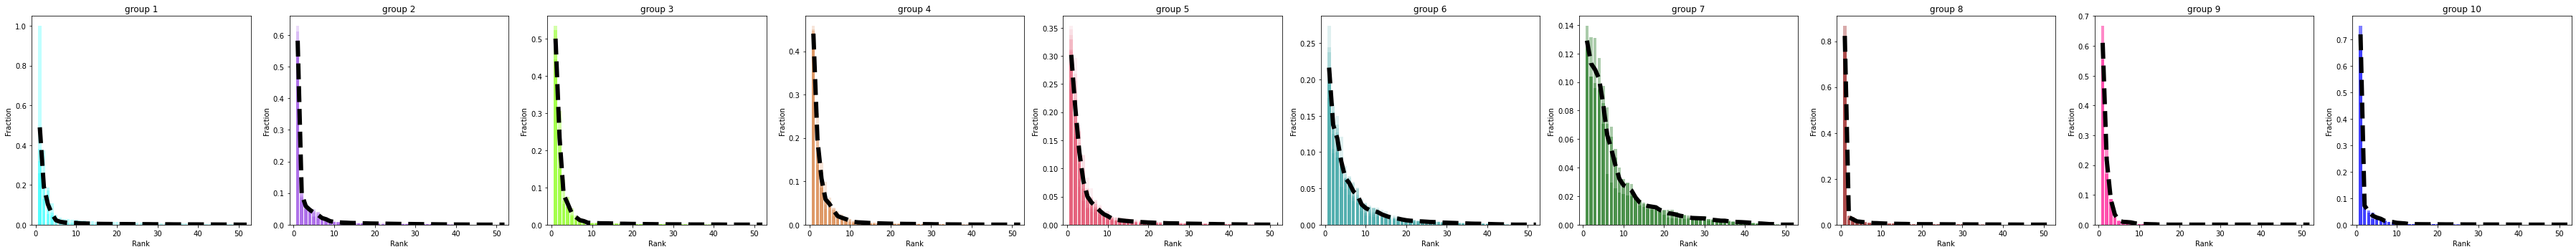

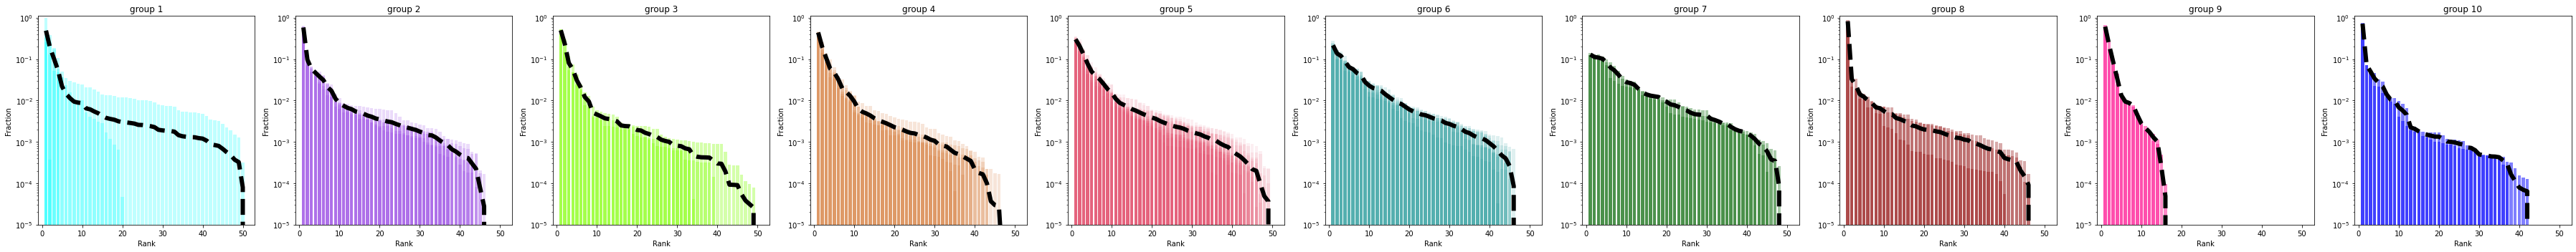

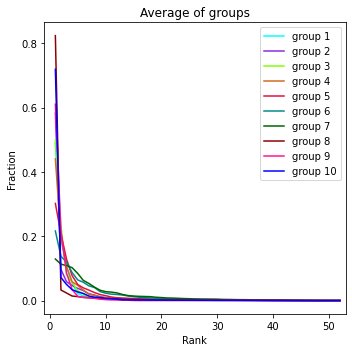

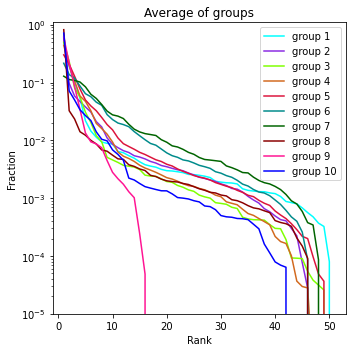

In [23]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'first of Auguest'
thr = 0.5
linkage_method = 'average'
df = preprocess(path)
plot_signiture(df,title_name)
plot_signiture(df,title_name, scale = 'log')
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
group = plot_dendrogram(dist_mat,thr, linkage_method)
plot_clustered_cities(group, title_name)
group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = None)
plot_average_clusters(group,group_avg, scale = 'log')

<ipython-input-12-5a2bf0b01af2>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,linkage_method)


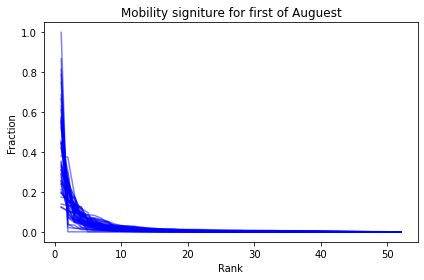

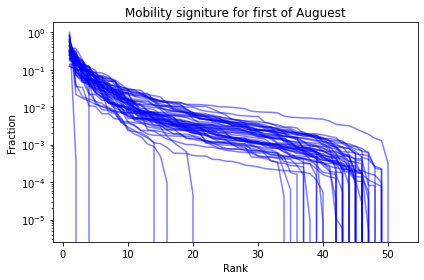

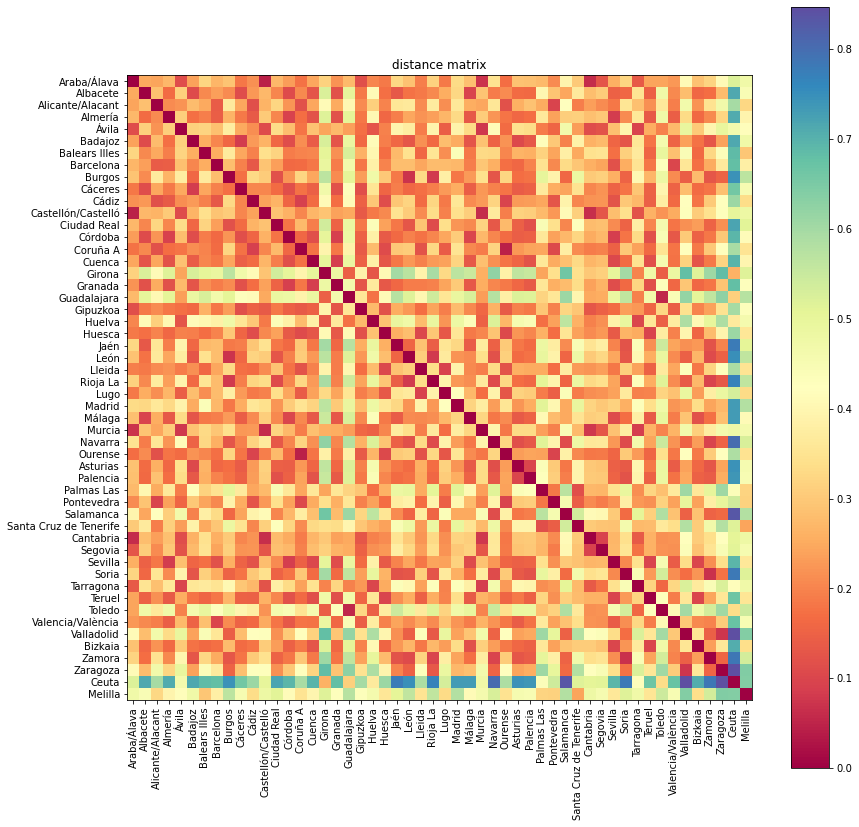

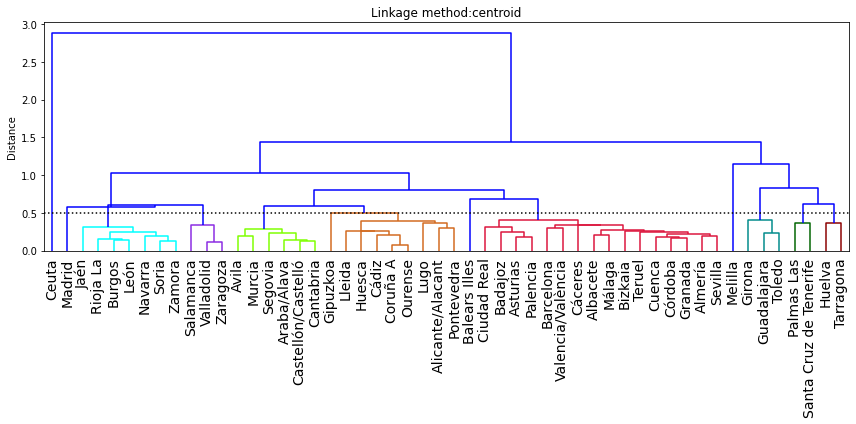

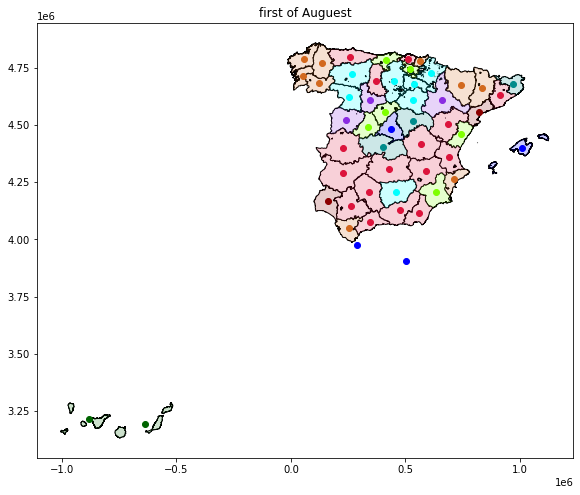

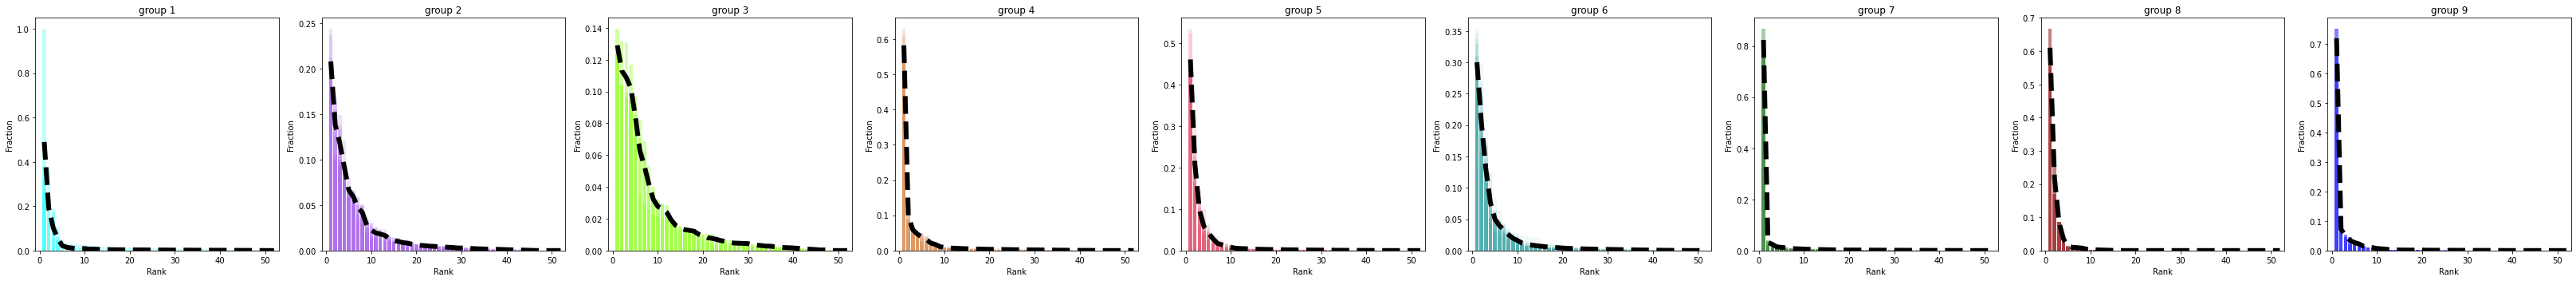

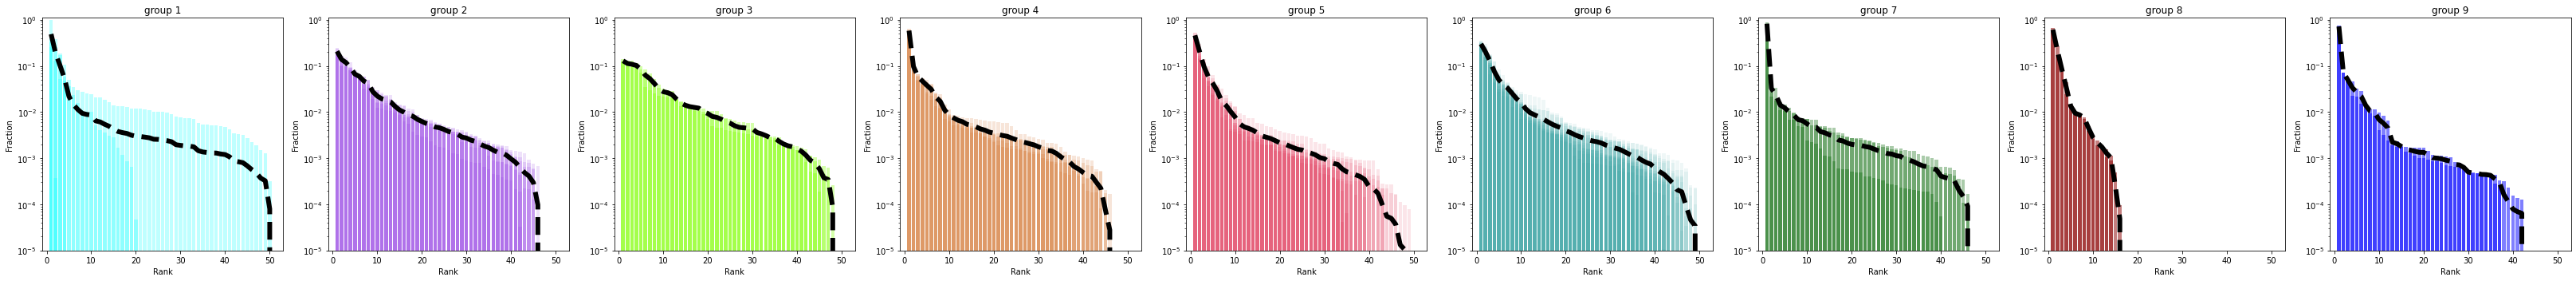

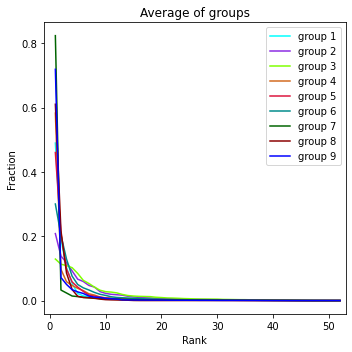

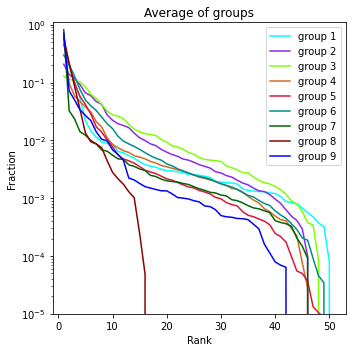

In [24]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'first of Auguest'
thr = 0.5
linkage_method = 'centroid'
df = preprocess(path)
plot_signiture(df,title_name)
plot_signiture(df,title_name, scale = 'log')
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
group = plot_dendrogram(dist_mat,thr, linkage_method)
plot_clustered_cities(group, title_name)
group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = None)
plot_average_clusters(group,group_avg, scale = 'log')

<ipython-input-12-5a2bf0b01af2>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x = linkage(dist_mat,linkage_method)


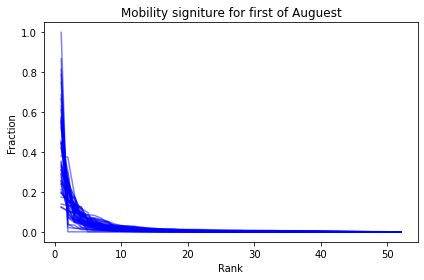

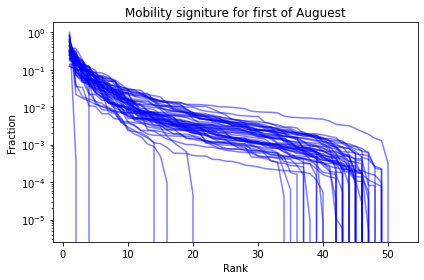

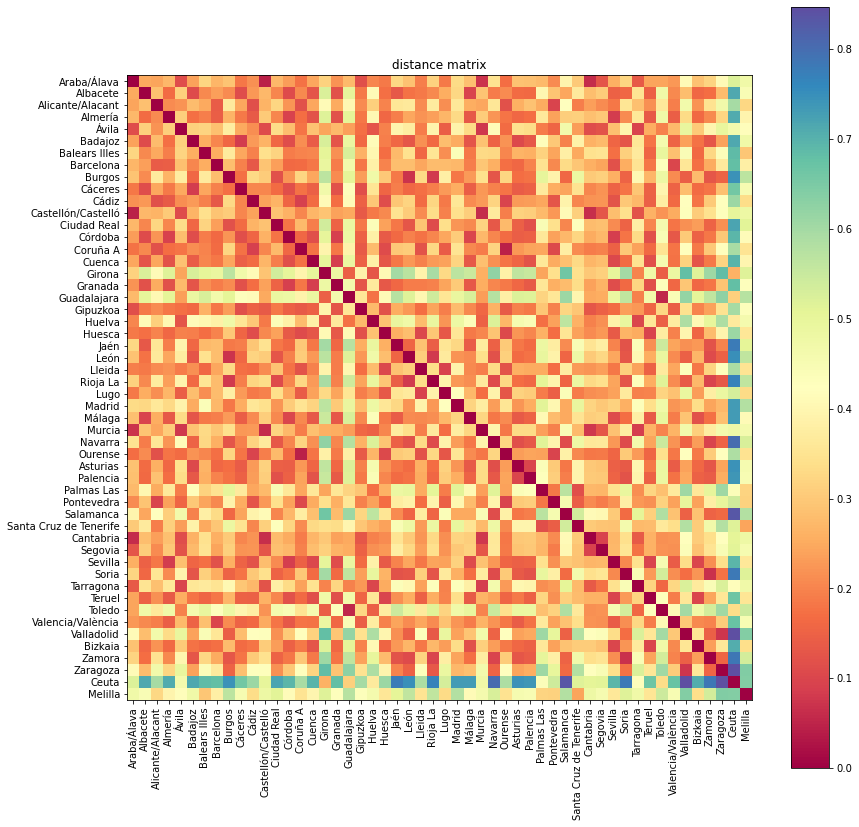

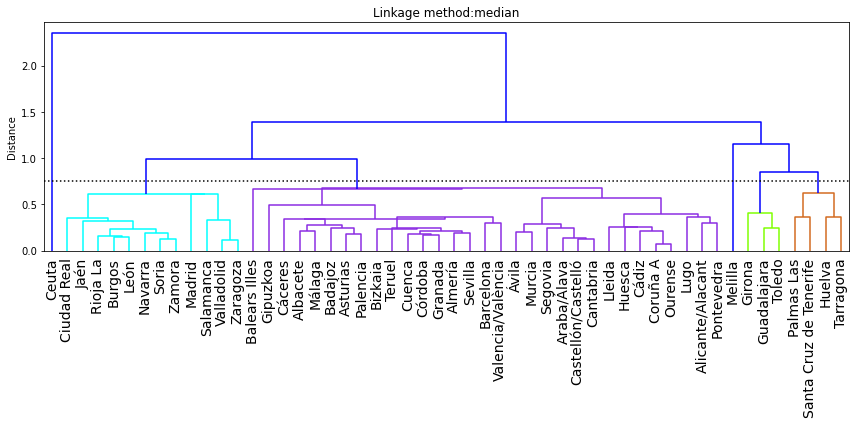

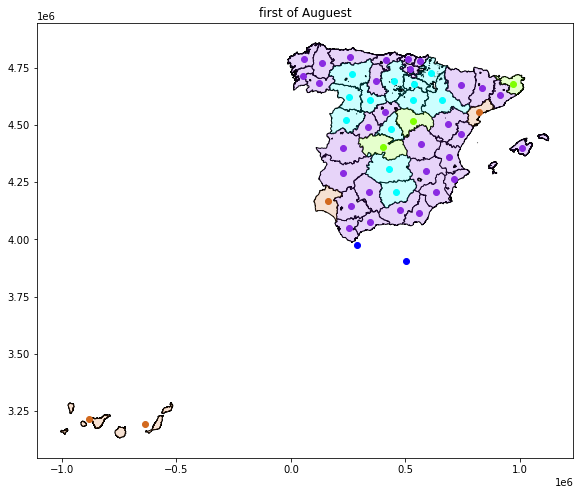

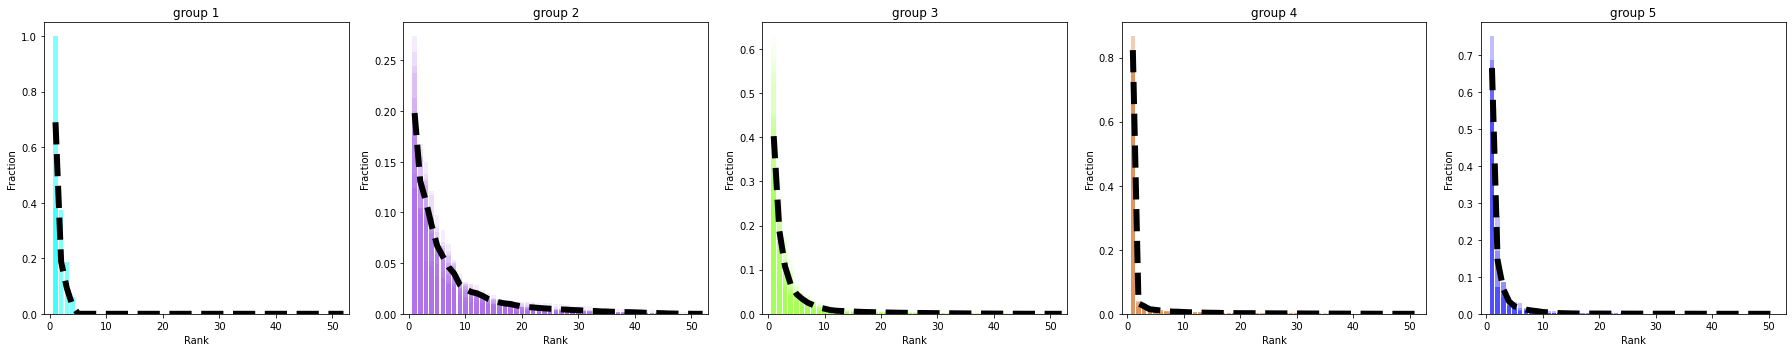

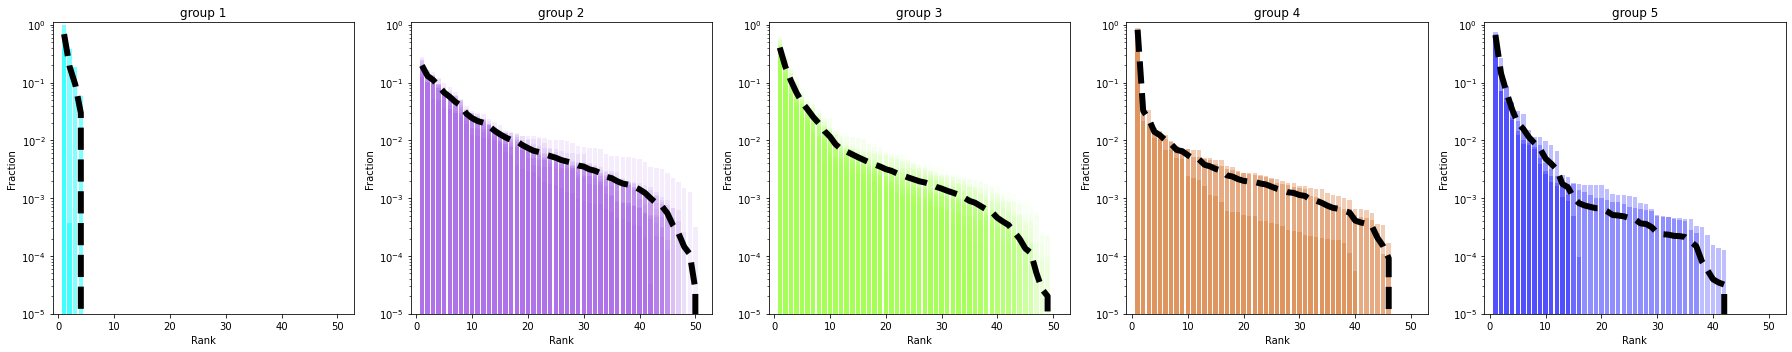

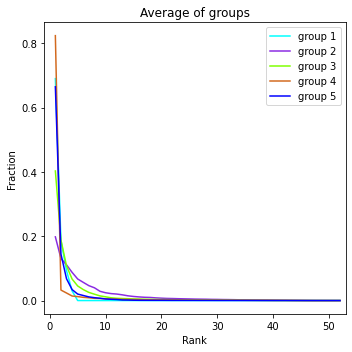

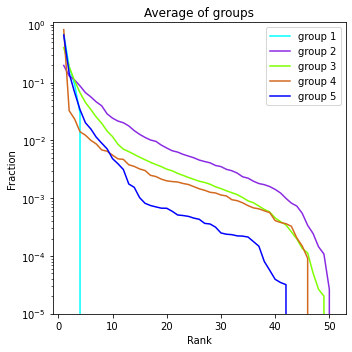

In [25]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'first of Auguest'
thr =0.75
linkage_method = 'median'
df = preprocess(path)
plot_signiture(df,title_name)
plot_signiture(df,title_name, scale = 'log')
dist_mat = get_distance_matrix(df)
plot_distance_matrix(dist_mat)
group = plot_dendrogram(dist_mat,thr, linkage_method)
plot_clustered_cities(group, title_name)
group_avg = plot_groups(group,df,scale = None)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = None)
plot_average_clusters(group,group_avg, scale = 'log')

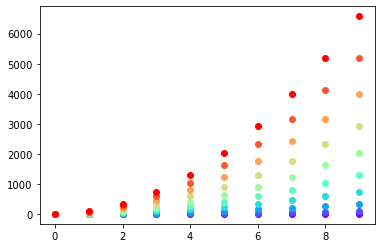

In [27]:
import matplotlib.cm as cm

x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for y, c in zip(ys, colors):
    plt.scatter(x, y, color=c)

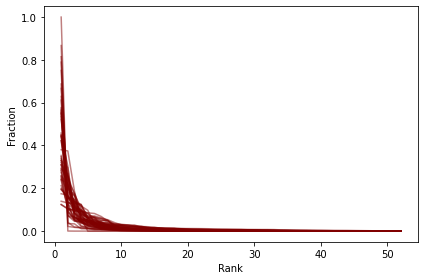

In [45]:
plt.figure()

rank = list(range(1, 53))
destino_distributions = {}
destino_norm_distributions = {}
for i in range(1, 53):
    origen = str(i).zfill(2)
    destino_distributions[origen] = get_destino_distribution(df,Origen=origen)
    destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

plt.subplot(1, 1, 1)
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(1, 1, 53))))
for i in range(1, 53):
    destino_distribution = destino_distributions[str(i).zfill(2)]
    plt.plot(rank, destino_distribution.norm_weight, alpha=0.5)
plt.xlabel('Rank')
plt.ylabel('Fraction')
plt.tight_layout()

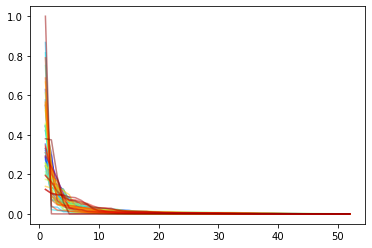

In [47]:

num_plots = 52

# Have a look at the colormaps here and decide which one you'd like:
# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

# Plot several 
for i in range(1, num_plots + 1):
    destino_distribution = destino_distributions[str(i).zfill(2)]
    plt.plot(rank, destino_distribution.norm_weight, alpha=0.5)